In [113]:
import numpy as np
import math
import matplotlib as mpl
mpl.use("agg")
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sys
%matplotlib inline

In [114]:
class Logger:
    def __init__(self, dim):
        self.dim = dim
        self.index_key = ["g", "evals"]
        self.scalar_key = ["fval", "sigma"]
        self.vector_key = ["mean", "sqrteig"]
        self.log = self.init_log_dict()

    def init_log_dict(self):
        log = dict()
        for k in self.index_key + self.scalar_key:
            log[k] = []
        for k in self.vector_key:
            for i in range(self.dim):
                log[f"{k}{i}"] = []
        return log

    def generate_log(self, g, evals, fval, sigma, mean, B):
        self.log["g"].append(g)
        self.log["evals"].append(evals)
        self.log["fval"].append(fval)
        self.log["sigma"].append(sigma)
        D = np.linalg.eigvalsh(sigma**2 * B.dot(B.T))
        D = np.sqrt(D)
        for i in range(self.dim):
            self.log[f"mean{i}"].append(mean[i, 0])
            self.log[f"sqrteig{i}"].append(D[i])

    def plot(self, fname):
        mpl.rc("lines", linewidth=0.5, markersize=8)
        mpl.rc("font", size=12)
        mpl.rc("grid", color="0.75", linestyle=":")
        mpl.rc("ps", useafm=True)  # force to use
        mpl.rc("pdf", use14corefonts=True)  # only Type 1 fonts
        mpl.rc("text", usetex=True)  # for a paper submission
        mpl.rc("xtick", labelsize=6)
        from cycler import cycler

        mpl.rc("axes", prop_cycle=cycler(color="bgrcmyk"))

        variable_list = self.scalar_key + self.vector_key
        log = self.log
        nfigs = len(variable_list)
        ncols = int(np.ceil(np.sqrt(nfigs)))
        nrows = int(np.ceil(nfigs / ncols))
        # figsize = (4 * ncols, 3 * nrows)
        figsize = (6 * ncols, 3 * nrows)
        axdict = dict()
        # Figure
        fig = plt.figure(figsize=figsize)

        def plot_fval(idx):
            ax = plt.subplot(nrows, ncols, idx)
            ax.set_title(r"$f(m)$")
            ax.grid(True)
            ax.grid(which="major", linewidth=0.50)
            ax.grid(which="minor", linewidth=0.25)
            ax.set_yscale("log")
            plt.plot(log["evals"], log["fval"])

        def plot_mean(idx):
            ax = plt.subplot(nrows, ncols, idx)
            ax.set_title(r"$m$")
            ax.grid(True)
            ax.grid(which="major", linewidth=0.50)
            ax.grid(which="minor", linewidth=0.25)
            for i in range(self.dim):
                plt.plot(
                    log["evals"], log[f"mean{i}"], color=cm.hsv(float(i) / self.dim)
                )

        def plot_sigma(idx):
            ax = plt.subplot(nrows, ncols, idx)
            ax.set_title(r"$\sigma$ (step-size)")
            ax.grid(True)
            ax.grid(which="major", linewidth=0.50)
            ax.grid(which="minor", linewidth=0.25)
            ax.set_yscale("log")
            plt.plot(log["evals"], log["sigma"])

        def plot_sqrteig(idx):
            ax = plt.subplot(nrows, ncols, idx)
            ax.set_title(r"$\sqrt{\rm eig}$")
            ax.grid(True)
            ax.grid(which="major", linewidth=0.50)
            ax.grid(which="minor", linewidth=0.25)
            ax.set_yscale("log")
            for i in range(self.dim):
                plt.plot(
                    log["evals"], log[f"sqrteig{i}"], color=cm.hsv(float(i) / self.dim)
                )

        idx = 1
        if "fval" in variable_list:
            plot_fval(idx)
            idx += 1
        if "mean" in variable_list:
            plot_mean(idx)
            idx += 1
        if "sigma" in variable_list:
            plot_sigma(idx)
            idx += 1
        if "sqrteig" in variable_list:
            plot_sqrteig(idx)
            idx += 1

        plt.tight_layout()
        # plt.show()
        plt.savefig(f"./{fname}.png")
        return

class Solution(object):
    def __init__(self, dim):
        self.f = float("nan")
        self.x = np.zeros([dim, 1])
        self.z = np.zeros([dim, 1])

def expm_numpy(mat: np.ndarray) -> np.ndarray:
    D, U = np.linalg.eigh(mat)
    expD = np.exp(D)
    return U @ np.diag(expD) @ U.T

In [115]:
def get_h_inv(dim: int) -> float:
    def f(a):
        return ((1.0 + a * a) * math.exp(a * a / 2.0) / 0.24) - 10.0 - dim

    def fprime(a):
        return (1.0 / 0.24) * a * math.exp(a * a / 2.0) * (3.0 + a * a)

    h_inv = 5.0
    while abs(f(h_inv)) > 1e-10:
        h_inv = h_inv - 0.5 * (f(h_inv) / fprime(h_inv))
    return h_inv


def dxnesic_main(obj_func, dim, lamb, mean, sigma, max_evals, criterion=1e-8, logger=None, seed=123):
    # validation
    assert isinstance(dim, int)
    assert isinstance(lamb, int)
    assert isinstance(mean, float)
    assert isinstance(sigma, float)
    assert isinstance(seed, int)
    assert isinstance(max_evals, int)

    np.random.seed(seed)
    if logger is None:
        logger = Logger(dim=dim)
    # constant
    wrh = math.log(lamb / 2.0 + 1.0) - np.log(np.arange(1, lamb + 1))
    w_rank_hat = np.maximum([0 * lamb], wrh)
    w_rank = w_rank_hat / sum(w_rank_hat) - 1.0 / lamb
    mueff = 1 / np.sum((w_rank + 1.0 / lamb) ** 2, axis=0)
    cs = (mueff + 2.0) / (dim + mueff + 5.0)
    chiN = np.sqrt(dim) * (1.0 - 1.0 / (4.0 * dim) + 1.0 / (21.0 * dim * dim))
    eta_m = 1.0
    I = np.eye(dim, dtype=float)

    # learning rate
    eta_move_sigma = 1.0
    eta_stag_sigma = lambda lambF: math.tanh(
        (0.024 * lambF + 0.7 * dim + 20.0) / (dim + 12.0)
    )
    eta_conv_sigma = lambda lambF: 2.0 * math.tanh(
        (0.025 * lambF + 0.75 * dim + 10.0) / (dim + 4.0)
    )
    eta_move_B = (
        lambda lam_feas: 180
        * dim
        * math.tanh(0.02 * lam_feas)
        / (47 * (dim**2) + 6400)
    )
    eta_stag_B = (
        lambda lam_feas: 168
        * dim
        * math.tanh(0.02 * lam_feas)
        / (47 * (dim**2) + 6400)
    )
    eta_conv_B = (
        lambda lam_feas: 12
        * dim
        * math.tanh(0.02 * lam_feas)
        / (47 * (dim**2) + 6400)
    )
    # eiadx-nes
    c_gamma = 1.0 / (3.0 * (dim - 1.0))
    d_gamma = min(1.0, dim / lamb)
    gamma = 1.0

    # dynamic
    mean = np.array([mean] * dim).reshape(dim, 1)
    B = np.eye(dim, dtype=float)
    ps = np.zeros([dim, 1])
    evals = 0
    g = 0
    best = np.inf
    sols = [Solution(dim) for _ in range(lamb)]

    # distance weight parameter
    h_inv = get_h_inv(dim)
    alpha_dist = (
        lambda lamb_feas: h_inv
        * min(1.0, math.sqrt(lamb / dim))
        * math.sqrt(lamb_feas / lamb)
    )
    w_dist_hat = lambda z, lamb_feas: math.exp(
        alpha_dist(lamb_feas) * np.linalg.norm(z)
    )

    while evals < max_evals:
        g += 1

        nan_exists = False
        for i in range(int(lamb / 2)):
            sols[2 * i].z = np.random.randn(dim, 1)
            sols[2 * i + 1].z = -sols[2 * i].z.copy()
            sols[2 * i].x = mean + sigma * B.dot(sols[2 * i].z)
            sols[2 * i + 1].x = mean + sigma * B.dot(sols[2 * i + 1].z)
            sols[2 * i].f = obj_func(sols[2 * i].x)
            sols[2 * i + 1].f = obj_func(sols[2 * i + 1].x)
            if sols[2 * i].f is np.nan or sols[2 * i + 1].f is np.nan:
                nan_exists = True
        evals += lamb

        if nan_exists:
            break

        sols = sorted(sols, key=lambda s: s.f)
        fm = obj_func(mean)
        print("#evals:{}, f(m):{}".format(evals, fm)) if g % 1000 == 0 else None

        if fm < criterion:
            break

        logger.generate_log(
            g=g, evals=evals, fval=fm, sigma=sigma, mean=mean, B=B
        )

        lamb_feas = len([sols[i] for i in range(lamb) if sols[i].f < sys.maxsize])

        # evolution path p_sigma
        wz = np.sum([w_rank[i] * sols[i].z for i in range(lamb)], axis=0)
        ps = (1.0 - cs) * ps + np.sqrt(cs * (2.0 - cs) * mueff) * wz
        ps_norm = np.linalg.norm(ps)
        movement_phase = ps_norm >= chiN

        # distance weight
        w_dist_tmp = np.array(
            [w_rank_hat[i] * w_dist_hat(sols[i].z, lamb_feas) for i in range(lamb)]
        )
        w_dist = w_dist_tmp / sum(w_dist_tmp) - 1.0 / lamb

        # switching weights and learning rate
        w = w_dist if movement_phase else w_rank
        eta_sigma = (
            eta_move_sigma
            if ps_norm >= chiN
            else eta_stag_sigma(lamb_feas)
            if ps_norm >= 0.1 * chiN
            else eta_conv_sigma(lamb_feas)
        )
        eta_B = (
            eta_move_B(lamb_feas)
            if ps_norm >= chiN
            else eta_stag_B(lamb_feas)
            if ps_norm >= 0.1 * chiN
            else eta_conv_B(lamb_feas)
        )

        # calculate natural gradient
        G_delta = np.sum([w[i] * sols[i].z for i in range(lamb)], axis=0)
        G_M = np.sum(
            [w[i] * (np.outer(sols[i].z, sols[i].z) - I) for i in range(lamb)], axis=0
        )
        G_sigma = G_M.trace() / dim
        G_B = G_M - G_sigma * I

        bBBT = B @ B.T
        mean += eta_m * sigma * np.dot(B, G_delta)
        sigma *= math.exp((eta_sigma / 2.0) * G_sigma)
        B = B.dot(expm_numpy((eta_B / 2.0) * G_B))
        aBBT = B @ B.T

        # expansion
        e, v = np.linalg.eigh(bBBT)
        tau_vec = [
            (v[:, i].reshape(dim, 1).T @ aBBT @ v[:, i].reshape(dim, 1))
            / (v[:, i].reshape(dim, 1).T @ bBBT @ v[:, i].reshape(dim, 1))
            - 1
            for i in range(dim)
        ]
        flg_tau = [1.0 if tau_vec[i] > 0 else 0.0 for i in range(dim)]
        tau = max(tau_vec)[0][0]
        gamma = max(
            (1.0 - c_gamma) * gamma + c_gamma * math.sqrt(1.0 + d_gamma * tau),
            1.0,
        )
        if movement_phase:
            Q = (gamma - 1.0) * np.sum(
                [flg_tau[i] * np.outer(v[:, i], v[:, i]) for i in range(dim)], axis=0
            ) + I
            stepQ = math.pow(np.linalg.det(Q), 1.0 / dim)
            sigma *= stepQ
            B = Q @ B / stepQ

    print(f"evals:{evals}, fm:{fm}")
    return logger

In [116]:
def sphere(x):
    return np.sum(x**2)


def ellipsoid(x):
    n = len(x)
    if len(x) < 2:
        raise ValueError("dimension must be greater one")
    Dell = np.diag([10 ** (3 * i / (n - 1)) for i in range(n)])
    return sphere(Dell @ x)


def rosenbrockchain(x):
    n = len(x)
    if len(x) < 2:
        raise ValueError("dimension must be greater one")
    # return np.sum([100*(x[i+1] - x[i]**2)**2 + (x[i] - 1)**2 for i in range(self.n-1)])
    return np.sum(100.0 * (x[1:] - x[:-1] ** 2) ** 2 + (1 - x[:-1]) ** 2)


def rastrigin(x):
    n = len(x)
    if n < 2:
        raise ValueError("dimension must be greater one")
    return 10 * n + sum(x**2 - 10 * np.cos(2 * np.pi * x))


evals:3180, fm:9.695205456040375e-07


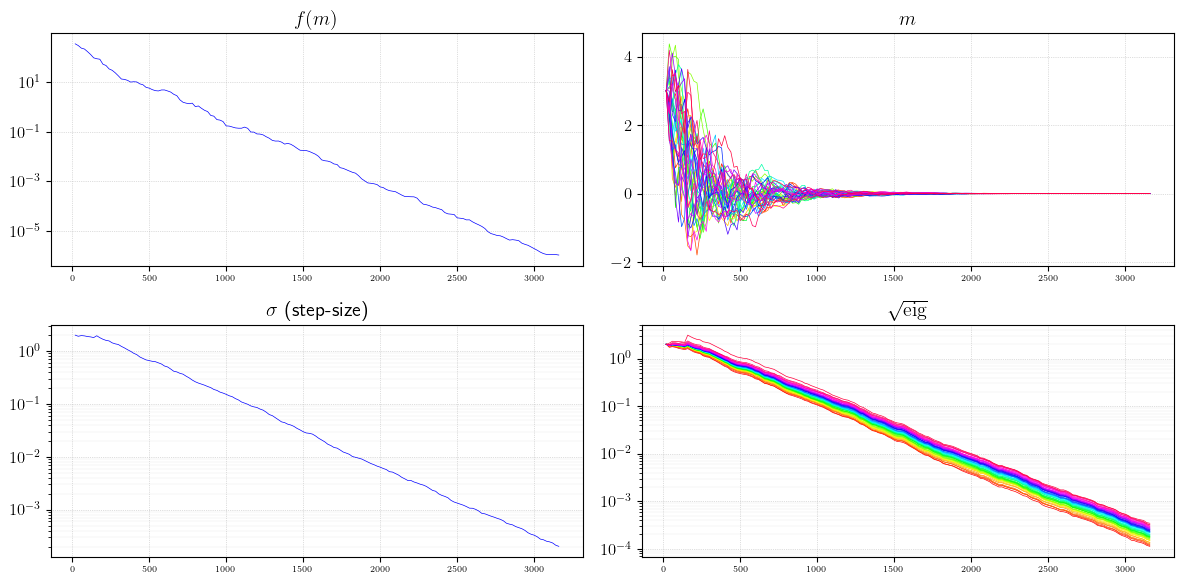

In [117]:
# experimental setup
obj_func = sphere
dim = 40
lamb = 20
mean = 3.0
sigma = 2.0
max_evals = 100000
criterion = 1e-6
logger = Logger(dim=dim)

logger = dxnesic_main(obj_func, dim, lamb, mean, sigma, max_evals, criterion, logger)
logger.plot(fname="dxnesic_behavior_sphere")

#evals:20000, f(m):39.61324139636882
#evals:40000, f(m):0.002238762238650018
evals:45580, fm:9.982624362838038e-07


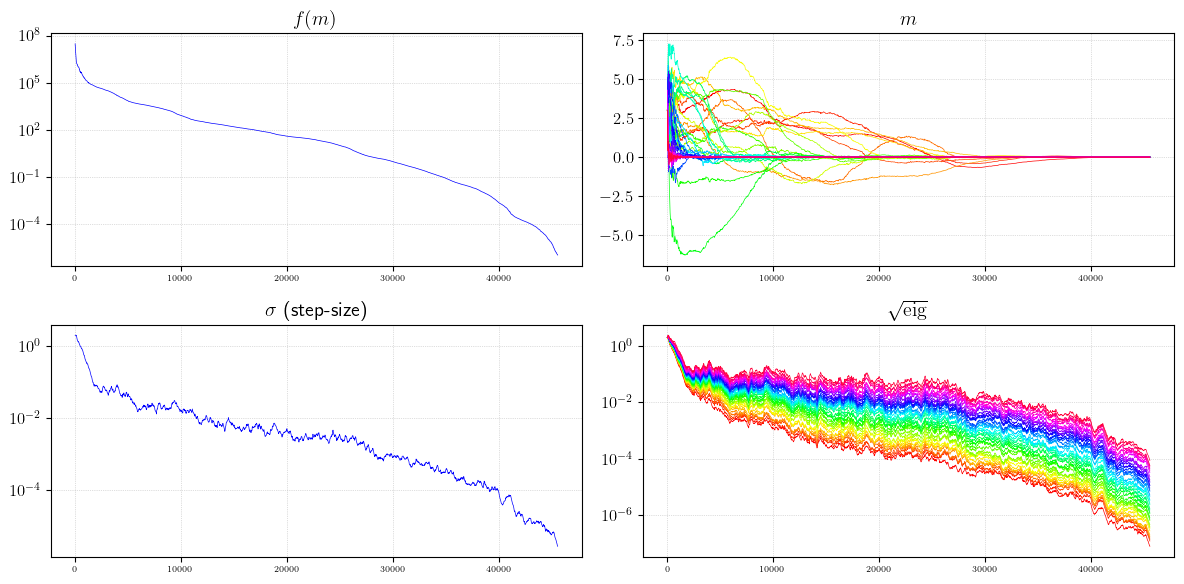

In [118]:
# experimental setup
obj_func = ellipsoid
dim = 40
lamb = 20
mean = 3.0
sigma = 2.0
max_evals = 100000
criterion = 1e-6
logger = Logger(dim=dim)

logger = dxnesic_main(obj_func, dim, lamb, mean, sigma, max_evals, criterion, logger)
logger.plot("dxnesic_behavior_ellipsoid")

#evals:20000, f(m):26.13117850284649
#evals:40000, f(m):14.488533938084002
#evals:60000, f(m):3.3789997608235227
evals:77060, fm:9.76369171545722e-07


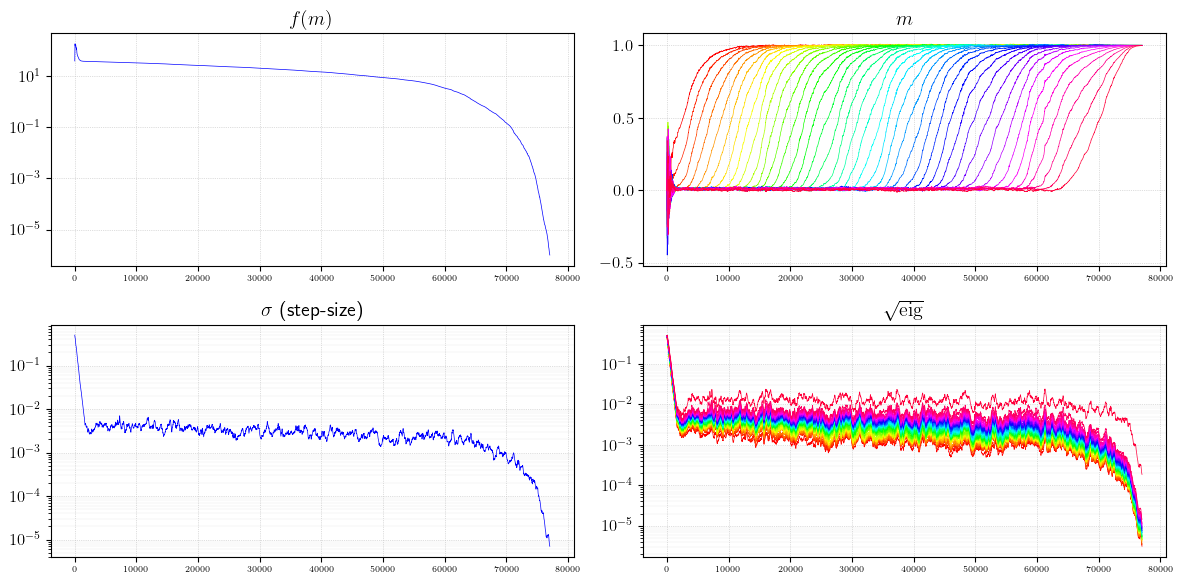

In [119]:
# experimental setup
obj_func = rosenbrockchain
dim = 40
lamb = 20
mean = 0.0
sigma = 0.5
max_evals = 100000
criterion = 1e-6
logger = Logger(dim=dim)

logger = dxnesic_main(obj_func, dim, lamb, mean, sigma, max_evals, criterion, logger)
logger.plot("dxnesic_behavior_rosenbrock")

evals:214000, fm:[7.25796326e-07]


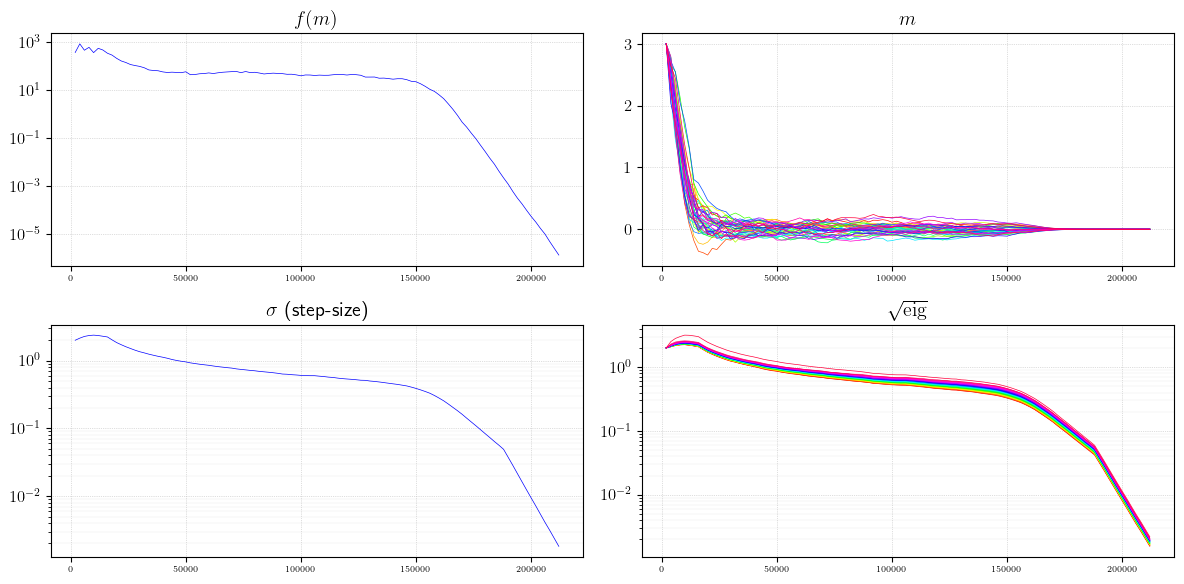

In [120]:
# experimental setup
obj_func = rastrigin
dim = 40
lamb = 2000
mean = 3.0
sigma = 2.0
max_evals = 300000
criterion = 1e-6
logger = Logger(dim=dim)

logger = dxnesic_main(obj_func, dim, lamb, mean, sigma, max_evals, criterion, logger)
logger.plot("dxnesic_behavior_rastrigin_pop2000")